<a href="https://colab.research.google.com/github/lindseyvanosky/food_sales_predictions/blob/main/LV_Project_1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sales Predictions: Project 1 Final
####Prepping Data for Machine Learning, Building Models and Model Evaluation
- Lindsey Vanosky 
- 06.29.22

#Import, Upload & Inspect

In [279]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
import seaborn as sns
import matplotlib.pyplot as plt
set_config(display='diagram')


df = pd.read_csv("/content/drive/MyDrive/Coding Dojo/02 Stack 2: Intro to Machine Learning/Data Sets/Copy of sales_predictions.csv")
df.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [281]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [282]:
df.duplicated().sum()

0

#####Dropping irrelevant columns

In [283]:
df.drop(columns = ["Item_Identifier", "Outlet_Identifier", "Outlet_Establishment_Year", "Item_Weight"], inplace = True)

##Define Features and Validation Split

In [284]:
y = df["Item_Outlet_Sales"]
x = df.drop(columns = "Item_Outlet_Sales")
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

##Imputation

###Value Counts

In [285]:
for col in df.columns:
  display(df[col].value_counts())
  print('\n')

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Item_MRP, Length: 5938, dtype: int64

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

958.7520     17
1342.2528    16
703.0848     15
1845.5976    15
1278.3360    14
             ..
4124.6310     1
6622.7126     1
1614.5650     1
5602.7070     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64

##Building Column Selectors and Transformers 

In [286]:
object_selector = make_column_selector(dtype_include="object")
number_selector = make_column_selector(dtype_include="number")

In [287]:
freq_imputer = SimpleImputer(strategy = "most_frequent")
mean_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False)


##Building Pipelines

In [288]:
numeric_pipeline = make_pipeline(mean_imputer, scaler)
cat_pipeline = make_pipeline(freq_imputer, ohe)


#Column Transform

In [289]:
num_tuple = (numeric_pipeline, number_selector)
cat_tuple = (cat_pipeline, object_selector)
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6b67c4910>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6b67c4950>)])

#Fitting on Train Data

In [290]:
preprocessor.fit(x_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6b67c4910>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6b67c4950>)])

#Transforming Data

In [291]:
x_train_processed = preprocessor.transform(x_train)
x_test_processed = preprocessor.transform(x_test)

In [292]:
print(np.isnan(x_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(x_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', x_train_processed.dtype)
print('All data in X_test_processed are', x_test_processed.dtype)
print('\n')
print('shape of data is', x_train_processed.shape)
print('\n')
x_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 33)




array([[-0.71277507,  1.82810922,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

In [293]:
x_train_df = pd.DataFrame(x_train_processed)
x_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.712775,1.828109,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.291052,0.603369,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.813319,0.244541,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.004931,-0.952591,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.965484,-0.336460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#Linear Regression

####Determining Correlations

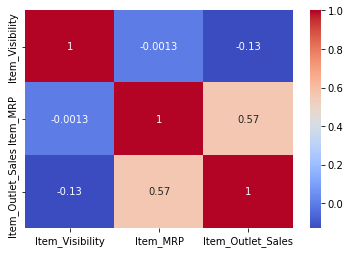

In [294]:
corr = df.corr()
sns.heatmap(corr, cmap = "coolwarm", annot = True);

Based off of these correlations, it looks like we can drop the Item Weight column, as it does not provide any correlation across the features. Knowing this, I am going to add "Item Weight" to the dropped columns above. Meaning Item Weight is no longer represented in this heatmap. We will keep the remaining features. 

###Instantiation

In [295]:
reg = LinearRegression()
reg_pipe = reg.fit(x_train_processed, y_train)

###Creating Predictions

In [296]:
train_pred = reg_pipe.predict(x_train_processed)
test_pred = reg_pipe.predict(x_test_processed)

###Evaluating r2

In [297]:
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(train_r2)
print(test_r2)

0.5607074795470389
0.5655273175721165


###Evaluating RMSE

In [298]:
train_MSE = mean_squared_error(y_train, train_pred)
test_MSE = mean_squared_error(y_test, test_pred)

train_RMSE = np.sqrt(train_MSE)
test_RMSE = np.sqrt(test_MSE)

print(train_RMSE)
print(test_RMSE)

1140.2046989950381
1094.8517082194119


Based on these two metrics, we can see that our r2 score explains 56% of the data, which is not good. However, while our RMSE score looks good, those numbers are representing millions of dollars. RMSE is telling us that on average, we have a difference of 1,094,851 which is a lot of money! We should not use this model as it is underfitting. Since linear regressions do not have hyperparameters to tune, we should not use this model. 

#Regression Tree

In [299]:
reg_tree = DecisionTreeRegressor(random_state = 42)
reg_tree.fit(x_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

###Original Reg Tree Score

In [300]:
train_score = reg_tree.score(x_train_processed, y_train)
test_score = reg_tree.score(x_test_processed, y_test)
print(train_score)
print(test_score)

1.0
0.18877812465258292


###Hyperparameter Tuning

In [301]:
reg_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [302]:
reg_tree.get_depth()

39

In [303]:
reg_tree.get_n_leaves()

6264

####Finding the optimal number of max_leaf_nodes

In [316]:
leaves = list(range(2, 1000))
scores = pd.DataFrame(index = leaves, columns=['Test Score','Train Score'])
for leaves in leaves:
    reg_tree = DecisionTreeRegressor(max_leaf_nodes = leaves, random_state=42)
    reg_tree.fit(x_train_processed, y_train)
    train_score_2 = reg_tree.score(x_train_processed, y_train)
    test_score_2 = reg_tree.score(x_test_processed, y_test)
    scores.loc[leaves, 'Train Score'] = train_score_2
    scores.loc[leaves, 'Test Score'] = test_score_2
sort_scores_2 = scores.sort_values(by = "Test Score", ascending = False)
sort_scores_2.head()


,Test Score,Train Score
11,0.58985,0.590147
12,0.589459,0.594329
13,0.588654,0.596809
28,0.587154,0.619227
24,0.586629,0.615045


In [317]:
reg_tree = DecisionTreeRegressor(min_samples_leaf = 5, max_leaf_nodes = 11, random_state = 42)
reg_tree.fit(x_train_processed, y_train)

DecisionTreeRegressor(max_leaf_nodes=11, min_samples_leaf=5, random_state=42)

In [318]:
train_score = reg_tree.score(x_train_processed, y_train)
test_score = reg_tree.score(x_test_processed, y_test)
print(train_score)
print(test_score)

0.5901466389903046
0.5898501176377509


We can see that the model is currently underfitting

####Finding the optimal min_samples_leaf

In [307]:
sample_leaf_min = list(range(2, 20))
scores = pd.DataFrame(index = sample_leaf_min, columns=['Test Score','Train Score'])
for sample_leaf_min in sample_leaf_min:
    reg_tree = DecisionTreeRegressor(min_samples_leaf = sample_leaf_min, random_state=42)
    reg_tree.fit(x_train_processed, y_train)
    train_score_3 = reg_tree.score(x_train_processed, y_train)
    test_score_3 = reg_tree.score(x_test_processed, y_test)
    scores.loc[sample_leaf_min, 'Train Score'] = train_score_3
    scores.loc[sample_leaf_min, 'Test Score'] = test_score_3
sort_scores = scores.sort_values(by = "Test Score", ascending = False)
sort_scores.head()

,Test Score,Train Score
19,0.5453,0.657434
18,0.537353,0.66076
15,0.533862,0.671214
17,0.533602,0.664059
16,0.531824,0.667796


In [308]:
reg_tree = DecisionTreeRegressor(min_samples_leaf = 19, max_leaf_nodes = 1004, random_state = 42)
reg_tree.fit(x_train_processed, y_train)

DecisionTreeRegressor(max_leaf_nodes=1004, min_samples_leaf=19, random_state=42)

In [309]:
train_score_4 = reg_tree.score(x_train_processed, y_train)
test_score_4 = reg_tree.score(x_test_processed, y_test)
print(train_score_4)
print(test_score_4)

0.6574336701294772
0.5452999741204319


We can see by these scores that the model is underfitting, but getting better! 

####Finding the optimal depth

In [311]:
depths = list(range(2, 50))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    reg_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    reg_tree.fit(x_train_processed, y_train)
    train_score_5 = reg_tree.score(x_train_processed, y_train)
    test_score_5 = reg_tree.score(x_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score_5
    scores.loc[depth, 'Test Score'] = test_score_5
sort_scores_5 = scores.sort_values(by = "Test Score", ascending = False)
sort_scores_5.head()


,Test Score,Train Score
5,0.594757,0.603917
6,0.585825,0.614946
4,0.584005,0.582625
7,0.581531,0.626298
8,0.571732,0.641324


####Finding optimal min_sample_split

In [313]:
split = list(range(2, 20))
scores = pd.DataFrame(index = split, columns = ['Test Score','Train Score'])
for split in split:
    reg_tree = DecisionTreeRegressor(min_samples_split = split, random_state=42)
    reg_tree.fit(x_train_processed, y_train)
    train_score_6 = reg_tree.score(x_train_processed, y_train)
    test_score_6 = reg_tree.score(x_test_processed, y_test)
    scores.loc[split, 'Train Score'] = train_score_6
    scores.loc[split, 'Test Score'] = test_score_6
sort_scores_6 = scores.sort_values(by = "Test Score", ascending = False)
sort_scores_6.head()


,Test Score,Train Score
19,0.414689,0.783276
18,0.409964,0.790733
17,0.398429,0.797596
16,0.393378,0.803337
15,0.380672,0.811317


###Optimized Model with r2 score

In [319]:
reg_tree_new = DecisionTreeRegressor(min_samples_split = 19, max_depth = 5, max_leaf_nodes = 11, min_samples_leaf = 19, random_state = 42)
reg_tree_new.fit(x_train_processed, y_train)

train_score_new = reg_tree.score(x_train_processed, y_train)
test_score_new = reg_tree.score(x_test_processed, y_test)
print(train_score_new)
print(test_score_new)

0.5901466389903046
0.5898501176377509


###Optimized RMSE

In [321]:
reg_train_pred = reg_tree_new.predict(x_train_processed)
reg_test_pred = reg_tree_new.predict(x_test_processed)

In [322]:
reg_train_MSE = mean_squared_error(y_train, reg_train_pred)
reg_test_MSE = mean_squared_error(y_test, reg_test_pred)
print(reg_train_MSE)
print(reg_test_MSE)

1212942.867259526
1131594.2100340165


In [323]:
reg_train_RMSE = np.sqrt(reg_train_MSE)
reg_test_RMSE = np.sqrt(reg_test_MSE)
print(reg_train_RMSE)
print(reg_test_RMSE)

1101.3368545815244
1063.7641703093861


#Conclusion



Viewing these two models, we can see that we get consistent answers from both models. However, both models have an r score that represents only half of the data, and both models have an RMSE that represents over a million dollars in error. At this point I would recommend revisiting the data and tweak the including columns to provide stronger correlation. We need to make this model more complex as it is underfitting. 